# Battle of the Sexes - How Does Gender Affect UFC Fights?

How does gender affect peformance in UFC fights? 

In this notebook I explore this question by looking at a sample of female and male UFC fighters, and compare their striking stats, grappling stats, and fight results. 

The analysis I perform suggests that gender does indeed affect some key aspects of MMA performance. Looking at some key striking and grappling stats, we see female fights are higher paced, with a higher strike rate and more time spent grappling, whereas men's fights involve more measurable damage, specifically more knockdowns, knockouts, and submissions. Other areas showed no significant difference, e.g. strike accuracy, submission attempts, etc.

This is my first exploratory data analysis in Python, so all feedback is appreciated! As this is my first analysis, I wanted to practice using the main data analysis suite: Pandas, Numpy, and Matplotlib. I also wanted to demonstrate my SQL experience, so throughout this notebook I query the data using the built in Pandas function pd.read_sql. 

I scraped the data from ufcstats.com using a Python script I wrote, which you can find on my GitHub: https://github.com/remypereira99/UFC-Web-Scraping. 


## Setup

In [332]:
#Import libraries for loading dataset from csv file
import pandas as pd
import os
import sqlite3

#Import libraries for data analysis and visualisation.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

#Changes pyplot style to Seaborn for better visualisations
plt.style.use('seaborn')

In [331]:
#Loads data from csv file to Pandas dataframe
path = os.getcwd()
ufc_events = pd.read_csv(path + '/Backup CSV/ufc_event_data_06_07.csv', parse_dates = ['event_date'])
ufc_fights = pd.read_csv(path + '/Backup CSV/ufc_fight_data_clean_18_07.csv')
ufc_fighters = pd.read_csv(path + '/Backup CSV/ufc_fighter_data_clean_06_07.csv', parse_dates = ['fighter_dob'])
ufc_fight_stats = pd.read_csv(path + '/Backup CSV/ufc_fight_stat_data_clean_11_07.csv')
pd.options.display.max_columns = None

In [4]:
#Creates SQLite database 
ufc_database = sqlite3.connect('ufc_database.db')
c = ufc_database.cursor()

In [5]:
#Loads dataframes to SQLite database
#Allows me to run SQL queries with pandas library (.read_sql)
ufc_events.to_sql('ufc_events',ufc_database, if_exists = 'replace', index = False)
ufc_fights.to_sql('ufc_fights',ufc_database, if_exists = 'replace', index = False)
ufc_fighters.to_sql('ufc_fighters',ufc_database, if_exists = 'replace', index = False)
ufc_fight_stats.to_sql('ufc_fight_stats',ufc_database, if_exists = 'replace', index = False)

14148

### Stats Functions

Here I write some functions for the statistical tests I will be using later. 

The first function is cohensd(). There is no function for measuring effect size in SciPy, so I wrote a function to calculate Cohen's D to measure the magnitude of effect of gender on the chosen dependent variables.

The second function is ttest(). This function builds on the SciPy function ttend_ind() to run an independent samples t-test on two samples. Before running the t-test, this function checks whether the two samples have equal variance or not, then runs the appropriate test. In addition to running the test, the function also prints a summary of the test, including the difference of means and the Cohen's D effect size.

The third function is prop_ztest(). This function calculates a z-score for the difference of proportions of two samples. It then uses the SciPy function norm.sf() to calculate a p-value for this z-score. Finally, it prints a summary of the test.

In [334]:
#Function for calculating effect size (Cohen's D)
def cohensd(s1,s2):
    
    #Calculates the mean difference between s1 and s2
    if np.mean(s1) > np.mean(s2):
        mean_diff = np.mean(s1) - np.mean(s2)
    else:
        mean_diff = np.mean(s2) - np.mean(s1)
        
    #Calculates the pooled standard deviation of s1 and s2
    pooled_sd = np.sqrt(((np.var(s1)+np.var(s2))/2))[0]
    
    return mean_diff/pooled_sd

In [7]:
#Function to perform check if sample variances are equal, and perform relevant t-test
def ttest(s1,s2):
    
    #Calculate means of two samples and the difference of means
    mean_s1 = round(s1.mean()[0],2)
    mean_s2 = round(s2.mean()[0],2)
    if mean_s1 > mean_s2:
        diff_means = round((mean_s1 - mean_s2),2)
    else:
        diff_means = round((mean_s2 - mean_s1),2)
        
    #Calculate Cohen's D test for effect size
    cohensd_result = cohensd(s1,s2)

    
    #If variances are unequal (one sample variance more than 2x other sample variance)
    if np.var(s1)[0] > 2*(np.var(s2)[0]) or np.var(s2)[0] > 2*(np.var(s1)[0]):
        
        #Perform unequal variance (Welch's) t-test using ttest_ind from SciPy Stats module
        ttest_result = stats.ttest_ind(s1,s2,equal_var=True)

    else:
        
        #Perform equal variance t-test using ttest_ind from SciPy Stats module
        ttest_result = stats.ttest_ind(s1,s2,equal_var=True)
        
        
    #Print Test Summary
    print('H\u2080: x̄\u2081 - x̄\u2082 = 0',
          '\nH\u2081: x̄\u2081 - x̄\u2082 ≠ 0'
          '\n\nSample 1 (Female)\nn\u2081 =', len(s1), '| x̄\u2081 =', mean_s1, '| s\u00b2\u2081 =', round(np.var(s1)[0],2),
          '\n\nSample 2 (Male)\nn\u2082 =', len(s2), '| x̄\u2082 =', mean_s2,'| s\u00b2\u2082 =', round(np.var(s2)[0],2),
          '\n\nHypothesised Difference of Means = 0',
          '\nTest Difference of Means =', diff_means,
          '\nTest Statistic =', round(ttest_result[0][0],2),
          '\np-value =', ttest_result[1][0],
          '\nEffect Size =', round(cohensd_result,2))

In [273]:
#Function to perform two-tailed two-sample z-test for sample proportion
def prop_ztest(successes1,trials1,successes2,trials2):
    
    #Calculate sample proportions
    p1 = successes1/trials1
    p2 = successes2/trials2
    p = (successes1 + successes2)/(trials1 + trials2)
    
    #Calculate the difference of sample proportions
    diff_prop = p1-p2
        
    #Calculate proportion variance
    var1 = (p1*(1-p1))/trials1
    var2 = (p2*(1-p2))/trials2
    
    #Calculate pooled variance
    pooled_var = np.sqrt(var1+var2)
    
    #Standard error
    se = np.sqrt((p*(1-p))*((1/trials1)+(1/trials2)))
    
    #Calculate z-statistic
    z_stat = round(diff_prop[0],3)/se
    
    #Calculate p-value (two-tailed)
    p_value = stats.norm.sf(abs(z_stat))*2
    
    print('H\u2080: p̂\u2081 - p̂\u2082 = 0',
          '\nH\u2081: p̂\u2081 - p̂\u2082 ≠ 0'
          '\n\nSample 1 (Female)\nn\u2081 =', round(trials1[0]), '| p̂\u2081 =', round(p1[0],3), 
          '\n\nSample 2 (Male)\nn\u2082 =', round(trials2[0]), '| p̂\u2082 =', round(p2[0],3),
          '\n\nHypothesised Difference of Proportions = 0',
          '\nTest Difference of Proportions =', round(diff_prop[0],3),
          '\nTest Statistic =', round(z_stat[0],3),
          '\np-value =', p_value[0])


## Data

The data I will use for this experiment was scraped from ufcstats.com. The dataset contains data on every UFC fight and fighter since 1994. 

Since I want an equal number of males and females, I will use stratified random sampling to divide the population into two strata: male and female. I will then randomly select 200 fighters from each strata. As n=200 is greater than 10% of the female population we are sampling from (N=816), I will use sampling with replacement to ensure independence.

There is one key confounding variable I want to control for in this experiment: weight. Weight is a significant aspect of fighting, hence why fighters are divided into weight classes. Many fight metrics will vary based on weight class, such as number of strikes thrown:

In [338]:
pd.read_sql("""SELECT 
        weight_class,
        AVG(sig_strikes_att) AS average_strikes_thrown
    FROM
        ufc_fight_stats
    JOIN
        ufc_fights ON ufc_fights.fight_id = ufc_fight_stats.fight_id
    WHERE
        weight_class_rank IS NOT NULL
    GROUP BY
        weight_class
    ORDER BY
        weight_class_rank""",ufc_database)

,weight_class,average_strikes_thrown
0,Women's Strawweight,116.627376
1,Women's Flyweight,119.786802
2,Women's Bantamweight,102.786885
3,Women's Featherweight,95.375000
4,Flyweight,86.338435
5,Bantamweight,94.430626
6,Featherweight,97.452703
7,Lightweight,80.834015
8,Welterweight,78.547974
9,Middleweight,68.274603


Notice that average strikes thrown appears negatively correlated with weight. Other target variables are also correlated with weight, e.g. knockdowns, takedown attempts, etc. 

Given that women are lighter than men on average, this may bias the experiment if we compare men and women of all weights. Female weight classes range from 115lb to 145lb, while male weight classes range from 125lb to 265lb. If we do not control for weight, then even though we may detect a significant difference between men and women, the difference may be caused by weight differences rather than gender differences.

To control for this, I will only compare men and women competing at the same weight: flyweight, bantamweight, and featherweight. Any significant differences in fight stats between these two populations is therefore more likely to be caused by gender differences than if we did not control for weight differences.

## Methods

### Variables

This analysis will investigate whether gender affects striking performance, grappling performance, and fight result.

For striking performance, I will look at the effect of gender on the following dependent variables:

- Strikes Thrown (per Round)
- Strikes Landed (per Round)
- Strike Accuracy (per Round)
- Knockdowns (per Round)

All of these variables will be divded by the number of rounds, to account for the fact that not all fights are the same length. Some fights may end in a first round knockout, while others will go to a decision. In addition, championship fights are (maximum) 5 rounds, while all other fights are (maximum) 3.

Strikes thrown is a discrete quantitative variable that measures the number of punches, kicks, knees, and elbows that a fighter throws during a fight. Strikes landed is a discrete quantitative variable that measures to the number of these strikes that hit an opponent without being blocked. Strikes accuracy is a discrete quantitative variable that measures the number of successful strikes divided by the number of total strikes, and will therefore lie on the [0,1] interval. Knockdowns is a discrete quantitative variable that measures the number of times a figther knocks their opponent to the ground with strikes.

For grappling performance, I will examine these dependent variables:

- Takedown Attempts (per Round)
- Takedowns Landed (per Round)
- Takedown Success Rate
- Submission Attempts (per Round)
- Control Time (per Round)

Takedown attempts is a discrete quantitative variable that measures the number of times a fighter tries to shoot a takedown on their opponent. Takedowns landed is a discrete quantitative variable that measures the number of times a fighter successfully takes their opponent to the ground. Takedown success rate is a discrete quantitative variable that measures the the number of successful takedowns divided by the number of total takedowns. Control time is a discrete quantitative variable that measures the amount of time in seconds that a fighter is in a dominant grappling position over their opponent, e.g. holding them in the clinch or in top mount. As with striking, I will divide the total by the number of rounds.

Finally, I want to test the effect of gender on fight results. Fight results refers to the way a fight ends. There are three main ways a fight can end:

- KO/TKO 
- Submission 
- Decision 

A fight is rules a KO (knockout) if a fighter knocks their opponent unconscious. Similarly, a fight is rules a TKO (technical knockout) if a fighter is unable to intelligently defend themsevles from their opponent, e.g. if a fighter is covering up in a turtle position on the ground and receiving strikes without striking back. A fight is ruled a submission if (i) Fighter B 'taps out' to signal that they submit to Fighter A, (ii) Fighter B is choked unconscious by Fighter A, (iii) Fighter B is unable to continue as a result of an injury caused by a submission attempt by Fighter A, e.g. if Fighter A breaks Fighter B's arm. Finally, if both fighters continue until the end of the final round without the referee ending the fight, the fight goes to a deicsion. In this case, three judges each vote for who they believe won the fight, based on the 10-point must system. 

Each of these are nominal variables, and I will examine the effect of gender on their relative frequencies.


### Analysis

I will run three statistical tests on these variables. 

For the following variables:

- Strikes thrown
- Strikes landed
- Knockdowns
- Takedown attempts
- Takedowns landed
- Submission attempts
- Control time 

I will compare the difference of means using an non-directional independent samples t-test. This will determine whether there is a significant difference between the means for men and women with regard to theese variable. In addition to the t-test, I will also calculate Cohen's D to measure effect size, to see the magnitude of the effect that gender has on these stats.

For the following variables:

- Strike Accuracy
- Takedown Success Rate

I will compare the difference of proportions using a non-directional z-test. This will allow us to conclude whether there is a significant difference in proportions between men and women with regard to these variables.

Finally, for fight results, I will run a chi-squared test for independence. This test will tell us whether the way a fight ends depends on gender or not. I will then run a non-direction z-test for difference of proportions for each finish type, to see whether there is a significant difference between men and women in terms of decisions, KO/TKOs, and submissions. If the chi-squared test for independence shows that the overall distribution of fight results does significantly depend on gender, we will expect that there will also be a significant difference in proportions for at least one finish type.


### Results

After running these tests, I will report the results of the tests in the results section. I will present the results in a table for easy comparison, along with some key visuals to help understand the results.

## Sampling

In [22]:
#Define populations from which to draw the samples. 
#As I will be using stratified sampling, I divide the populations into male and female.

population_m = pd.read_sql("""SELECT 
        ufc_fight_stats.fight_id,
        ufc_fight_stats.fighter_id,
        gender,
        knockdowns,
        sig_strikes_att,
        sig_strikes_succ,
        takedown_att,
        takedown_succ,
        submission_att,
        ctrl_time
    FROM 
        ufc_fight_stats
    JOIN
        ufc_fights ON ufc_fights.fight_id = ufc_fight_stats.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        gender = 'M'
        AND weight_class IN ("Flyweight","Bantamweight","Featherweight")""",ufc_database)

population_f = pd.read_sql("""SELECT
        ufc_fight_stats.fight_id,
        ufc_fight_stats.fighter_id,
        gender,
        knockdowns,
        sig_strikes_att,
        sig_strikes_succ,
        takedown_att,
        takedown_succ,
        submission_att,
        ctrl_time
    FROM 
        ufc_fight_stats
    JOIN
        ufc_fights ON ufc_fights.fight_id = ufc_fight_stats.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        gender = 'F'
        AND weight_class IN ("Women's Flyweight","Women's Bantamweight","Women's Featherweight")""",ufc_database)

To avoid generating a different sample each time the notebook is run, I have commented out the code for generating the random sample, and saved the samples to a csv. If you would like to run the tests again with a new sample, simply un-comment the cell below.

In [190]:
#Use the Pandas function df.sample to draw a random sample of 200 fighters from each population. 

# sample_m = population_m.sample(n=200,replace=True)
# sample_f = population_f.sample(n=200,replace=True)

#Combine both samples into one dataframe for summary statistics
# sample = pd.concat([sample_m,sample_f])

In [335]:
#Save the sample to a csv file
sample_m.to_csv(path + '/sample_m.csv')
sample_f.to_csv(path + '/sample_f.csv')
sample.to_csv(path + '/sample.csv')

In [336]:
#Read dataframes from csv file
sample_m = pd.read_csv(path + '/sample_m.csv')
sample_f = pd.read_csv(path + '/sample_f.csv')
sample = pd.read_csv(path + '/sample.csv')

In [193]:
#Add the dataframes to the SQLite database to allow for querying of the data using SQL
sample_m.to_sql('sample_m',ufc_database, if_exists = 'replace', index = False)
sample_f.to_sql('sample_f',ufc_database, if_exists = 'replace', index = False)
sample.to_sql('sample',ufc_database, if_exists = 'replace', index = False)

400

Below is an overview of the samples:

In [194]:
pd.read_sql("""SELECT *
    FROM 
        sample_m""",ufc_database)

,Unnamed: 0,fight_id,fighter_id,gender,knockdowns,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,submission_att,ctrl_time
0,817,3593,3090.0,M,1.0,53.0,25.0,2.0,2.0,0.0,3:54
1,1982,5775,825.0,M,0.0,12.0,9.0,1.0,1.0,0.0,0:15
2,2161,6092,2398.0,M,0.0,35.0,19.0,2.0,2.0,3.0,4:41
3,2361,6427,1804.0,M,0.0,130.0,51.0,1.0,0.0,0.0,0:00
4,2459,6604,3965.0,M,0.0,159.0,97.0,1.0,1.0,0.0,1:25
...,...,...,...,...,...,...,...,...,...,...,...
195,1295,4524,3528.0,M,0.0,152.0,89.0,9.0,3.0,0.0,1:22
196,141,2377,3834.0,M,0.0,47.0,27.0,0.0,0.0,0.0,2:41
197,391,2798,2188.0,M,0.0,69.0,25.0,4.0,1.0,0.0,4:07
198,213,2506,1870.0,M,0.0,9.0,1.0,1.0,0.0,1.0,0:00


In [195]:
pd.read_sql("""SELECT *
    FROM 
        sample_f""",ufc_database)

,Unnamed: 0,fight_id,fighter_id,gender,knockdowns,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,submission_att,ctrl_time
0,156,4022,1969.0,F,0.0,144.0,80.0,7.0,1.0,0.0,5:53
1,265,4743,2468.0,F,0.0,95.0,37.0,2.0,1.0,0.0,1:28
2,791,6971,1591.0,F,0.0,104.0,76.0,1.0,0.0,0.0,1:07
3,773,6900,2081.0,F,0.0,204.0,101.0,2.0,2.0,0.0,0:19
4,592,6120,2193.0,F,0.0,82.0,35.0,0.0,0.0,0.0,0:00
...,...,...,...,...,...,...,...,...,...,...,...
195,305,4949,2290.0,F,0.0,197.0,107.0,11.0,2.0,2.0,1:14
196,750,6766,353.0,F,0.0,47.0,18.0,7.0,1.0,2.0,4:56
197,603,6155,2810.0,F,0.0,79.0,48.0,3.0,1.0,0.0,6:16
198,525,5821,2035.0,F,0.0,81.0,17.0,1.0,0.0,0.0,0:02


In [196]:
pd.read_sql("""SELECT *
    FROM 
        sample""",ufc_database)

,Unnamed: 0,fight_id,fighter_id,gender,knockdowns,sig_strikes_att,sig_strikes_succ,takedown_att,takedown_succ,submission_att,ctrl_time
0,817,3593,3090.0,M,1.0,53.0,25.0,2.0,2.0,0.0,3:54
1,1982,5775,825.0,M,0.0,12.0,9.0,1.0,1.0,0.0,0:15
2,2161,6092,2398.0,M,0.0,35.0,19.0,2.0,2.0,3.0,4:41
3,2361,6427,1804.0,M,0.0,130.0,51.0,1.0,0.0,0.0,0:00
4,2459,6604,3965.0,M,0.0,159.0,97.0,1.0,1.0,0.0,1:25
...,...,...,...,...,...,...,...,...,...,...,...
395,305,4949,2290.0,F,0.0,197.0,107.0,11.0,2.0,2.0,1:14
396,750,6766,353.0,F,0.0,47.0,18.0,7.0,1.0,2.0,4:56
397,603,6155,2810.0,F,0.0,79.0,48.0,3.0,1.0,0.0,6:16
398,525,5821,2035.0,F,0.0,81.0,17.0,1.0,0.0,0.0,0:02


## Gender and Striking Performance

### Strikes Thrown

In [375]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(sig_strikes_att/num_rounds),1) AS sig_strikes_thrown
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL
    GROUP BY sample.gender""",ufc_database)

,gender,sig_strikes_thrown
0,F,37.2
1,M,26.9


In [376]:
sig_strikes_thrown_f = pd.read_sql("""SELECT 
        sig_strikes_att/num_rounds AS strikes_thrown
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

sig_strikes_thrown_m = pd.read_sql("""SELECT 
        sig_strikes_att/num_rounds AS strikes_thrown
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

In [377]:
ttest(sig_strikes_thrown_f,sig_strikes_thrown_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 37.19 | s²₁ = 779.68 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 26.93 | s²₂ = 370.14 

Hypothesised Difference of Means = 0 
Test Difference of Means = 10.26 
Test Statistic = 4.27 
p-value = 2.4354208265301297e-05 
Effect Size = 0.43


### Strikes Landed

In [378]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(sig_strikes_succ/num_rounds),1) AS sig_strikes_landed
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL
    GROUP BY 
        sample.gender""",ufc_database)

,gender,sig_strikes_landed
0,F,16.5
1,M,12.0


In [379]:
sig_strikes_landed_f = pd.read_sql("""SELECT 
        sig_strikes_succ/num_rounds AS strikes_landed
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

sig_strikes_landed_m = pd.read_sql("""SELECT 
        sig_strikes_succ/num_rounds AS strikes_landed
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

In [380]:
ttest(sig_strikes_landed_f,sig_strikes_landed_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 16.51 | s²₁ = 182.49 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 11.96 | s²₂ = 84.91 

Hypothesised Difference of Means = 0 
Test Difference of Means = 4.55 
Test Statistic = 3.93 
p-value = 0.00010047607530553877 
Effect Size = 0.39


### Strike Accuracy

In [381]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND((SUM(sig_strikes_succ)/SUM(sig_strikes_att))*100,2)||' %' AS sig_strike_accuracy
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_succ IS NOT NULL
        AND sig_strikes_att IS NOT NULL
    GROUP BY 
        sample.gender""",ufc_database)

,gender,sig_strike_accuracy
0,F,44.3 %
1,M,44.2 %


In [382]:
sig_strike_acc_f = pd.read_sql("""SELECT 
        SUM(sig_strikes_succ) AS strikes_succ,
        SUM(sig_strikes_att) AS strikes_att
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_succ IS NOT NULL
        AND sig_strikes_att IS NOT NULL""",ufc_database)

sig_strike_acc_m = pd.read_sql("""SELECT 
        SUM(sig_strikes_succ) AS strikes_succ,
        SUM(sig_strikes_att) AS strikes_att
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        sig_strikes_succ IS NOT NULL
        AND sig_strikes_att IS NOT NULL""",ufc_database)

In [383]:
prop_ztest(sig_strike_acc_m['strikes_succ'].values,sig_strike_acc_m['strikes_att'].values,sig_strike_acc_f['strikes_succ'].values,sig_strike_acc_f['strikes_att'].values)

H₀: p̂₁ - p̂₂ = 0 
H₁: p̂₁ - p̂₂ ≠ 0

Sample 1 (Female)
n₁ = 17266 | p̂₁ = 0.442 

Sample 2 (Male)
n₂ = 23008 | p̂₂ = 0.443 

Hypothesised Difference of Proportions = 0 
Test Difference of Proportions = -0.001 
Test Statistic = -0.2 
p-value = 0.8415140979505897


### Knockdowns 

In [206]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(knockdowns/num_rounds),3) AS knockdowns
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        num_rounds IS NOT NULL
        AND knockdowns IS NOT NULL
    GROUP BY 
        sample.gender""",ufc_database)

,gender,knockdowns
0,F,0.022
1,M,0.063


In [207]:
knockdowns_f = pd.read_sql("""SELECT 
        knockdowns/num_rounds AS knockdowns
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        num_rounds IS NOT NULL
        AND knockdowns IS NOT NULL""",ufc_database)

knockdowns_m =  pd.read_sql("""SELECT 
        knockdowns/num_rounds AS knockdowns
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        num_rounds IS NOT NULL
        AND knockdowns IS NOT NULL""",ufc_database)

In [208]:
ttest(knockdowns_f,knockdowns_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 0.02 | s²₁ = 0.01 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 0.06 | s²₂ = 0.02 

Hypothesised Difference of Means = 0 
Test Difference of Means = 0.04 
Test Statistic = -3.26 
p-value = 0.0011976205570571122 
Effect Size = 0.33


## Gender and Grappling Performance

### Takedown Attempts

In [223]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(takedown_att/num_rounds),2) AS takedown_attempts
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att IS NOT NULL
        AND num_rounds IS NOT NULL
    GROUP BY 
        sample.gender""",ufc_database)

,gender,takedown_attempts
0,F,1.00
1,M,1.07


In [224]:
td_attempts_f = pd.read_sql("""SELECT 
        (takedown_att/num_rounds) AS takedown_attempts
    FROM
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

td_attempts_m = pd.read_sql("""SELECT 
        (takedown_att/num_rounds) AS takedown_attempts
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

In [225]:
ttest(td_attempts_f,td_attempts_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 1.0 | s²₁ = 1.1 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 1.07 | s²₂ = 1.79 

Hypothesised Difference of Means = 0 
Test Difference of Means = 0.07 
Test Statistic = -0.55 
p-value = 0.5841261136600941 
Effect Size = 0.05


### Takedowns Landed 

In [226]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(takedown_succ/num_rounds),2) AS takedowns_landed
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_succ IS NOT NULL
        AND num_rounds IS NOT NULL
    GROUP BY
        sample.gender""",ufc_database)

,gender,takedowns_landed
0,F,0.36
1,M,0.38


In [227]:
td_landed_f = pd.read_sql("""SELECT 
    (takedown_succ/num_rounds) AS takedowns_landed
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_succ IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

td_landed_m = pd.read_sql("""SELECT 
        (takedown_succ/num_rounds) AS takedowns_landed
    FROM
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_succ IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

In [228]:
ttest(td_landed_f,td_landed_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 0.36 | s²₁ = 0.17 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 0.38 | s²₂ = 0.32 

Hypothesised Difference of Means = 0 
Test Difference of Means = 0.02 
Test Statistic = -0.44 
p-value = 0.6618419200799376 
Effect Size = 0.04


### Takedown Success Rate

In [229]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(SUM(takedown_succ)/SUM(takedown_att)*100,1)||' %' AS takedown_success_rate
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att <> 0
        AND takedown_succ IS NOT NULL
        AND takedown_att IS NOT NULL
    GROUP BY 
        sample.gender""",ufc_database)

,gender,takedown_success_rate
0,F,35.8 %
1,M,35.4 %


In [230]:
takedown_succ_rate_f = pd.read_sql("""SELECT 
        SUM(takedown_succ) AS takedown_succ,
        SUM(takedown_att) AS takedown_att
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att <> 0
        AND takedown_succ IS NOT NULL
        AND takedown_att IS NOT NULL""",ufc_database)

takedown_succ_rate_m = pd.read_sql("""SELECT 
        SUM(takedown_succ) AS takedown_succ,
        SUM(takedown_att) AS takedown_att
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        takedown_att <> 0
        AND takedown_succ IS NOT NULL
        AND strftime('%Y', event_date) > '2012'""",ufc_database)

In [231]:
prop_ztest(takedown_succ_rate_f['takedown_succ'].values,takedown_succ_rate_f['takedown_att'].values,takedown_succ_rate_m['takedown_succ'].values,takedown_succ_rate_m['takedown_att'].values)

H₀: p̂₁ - p̂₂ = 0 
H₁: p̂₁ - p̂₂ ≠ 0

Sample 1 (Female)
n₁ = 618 | p̂₁ = 0.358 

Sample 2 (Male)
n₂ = 666 | p̂₂ = 0.354 

Hypothesised Difference of Proportions = 0 
Test Difference of Proportions = 0.003 
Test Statistic = 0.112 
p-value = 0.9106788786751739


### Submission Attempts

In [232]:
pd.read_sql("""SELECT 
        sample.gender,
        ROUND(AVG(submission_att/num_rounds),2) AS submission_attempts
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        submission_att IS NOT NULL
        AND num_rounds IS NOT NULL
    GROUP BY
        sample.gender""",ufc_database)

,gender,submission_attempts
0,F,0.11
1,M,0.14


In [233]:
sub_att_f = pd.read_sql("""SELECT 
        submission_att/num_rounds AS submission_attempts
    FROM 
        sample_f
    JOIN 
        ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        submission_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

sub_att_m = pd.read_sql("""SELECT 
        submission_att/num_rounds AS submission_attempts
    FROM 
        sample_m
    JOIN 
        ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        submission_att IS NOT NULL
        AND num_rounds IS NOT NULL""",ufc_database)

In [234]:
ttest(sub_att_f,sub_att_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 0.11 | s²₁ = 0.06 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 0.14 | s²₂ = 0.12 

Hypothesised Difference of Means = 0 
Test Difference of Means = 0.03 
Test Statistic = -0.93 
p-value = 0.3508805999692505 
Effect Size = 0.09


### Control Time

In [235]:
pd.read_sql("""SELECT 
        gender,
        AVG((CAST(SUBSTR(ctrl_time,1,delimiter-1) AS FLOAT)*60 + CAST(SUBSTR(ctrl_time,delimiter+1) AS FLOAT))/num_rounds) AS ctrl_time_seconds
    FROM (
        SELECT 
            INSTR(ctrl_time,':') AS delimiter,
            sample.fighter_id
            ctrl_time,
            sample.gender,
            num_rounds
        FROM 
            sample
        JOIN 
            ufc_fights ON sample.fight_id = ufc_fights.fight_id,
            ufc_events ON ufc_events.event_id = ufc_fights.event_id
        WHERE 
            ctrl_time IS NOT NULL
            AND num_rounds IS NOT NULL
        )
    GROUP BY
        gender""",ufc_database)

,gender,ctrl_time_seconds
0,F,83.924333
1,M,70.015905


In [236]:
ctrl_time_f = pd.read_sql("""SELECT 
        (CAST(SUBSTR(ctrl_time,1,delimiter-1) AS FLOAT)*60 + CAST(SUBSTR(ctrl_time,delimiter+1) AS FLOAT))/num_rounds AS ctrl_time_seconds
    FROM (
        SELECT 
            INSTR(ctrl_time,':') AS delimiter,
            ctrl_time,
            sample_f.gender,
            num_rounds
        FROM 
            sample_f
        JOIN 
            ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
            ufc_events ON ufc_events.event_id = ufc_fights.event_id
        WHERE 
            ctrl_time IS NOT NULL
        )""",ufc_database)

ctrl_time_m = pd.read_sql("""SELECT 
        (CAST(SUBSTR(ctrl_time,1,delimiter-1) AS FLOAT)*60 + CAST(SUBSTR(ctrl_time,delimiter+1) AS FLOAT))/num_rounds AS ctrl_time_seconds
    FROM (
        SELECT 
            INSTR(ctrl_time,':') AS delimiter,
            ctrl_time,
            sample_m.gender,
            num_rounds
        FROM 
            sample_m
        JOIN 
            ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
            ufc_events ON ufc_events.event_id = ufc_fights.event_id
        WHERE 
            ctrl_time IS NOT NULL)""",ufc_database)

In [237]:
ttest(ctrl_time_f,ctrl_time_m)

H₀: x̄₁ - x̄₂ = 0 
H₁: x̄₁ - x̄₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | x̄₁ = 58.51 | s²₁ = 3707.12 

Sample 2 (Male)
n₂ = 200 | x̄₂ = 41.87 | s²₂ = 2656.53 

Hypothesised Difference of Means = 0 
Test Difference of Means = 16.64 
Test Statistic = 2.94 
p-value = 0.003447414438005951 
Effect Size = 0.29


### Does Gender Affect Fight Results?

In [246]:
print('\033[1m' + 'Fight Results (Male)')
pd.read_sql("""SELECT 
        result,
        ROUND((CAST(COUNT(result) AS float)/total_result)*100,1)||'%' AS relative_freq,
        COUNT(result) AS frequency
    FROM (
            SELECT 
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample_m
            JOIN
                ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
            )
    GROUP BY 
        result""",ufc_database)

Fight Results (Male)


,result,relative_freq,frequency
0,Decision,45.5%,91
1,KO/TKO,30.0%,60
2,Submission,24.0%,48
3,TKO - Doctor's Stoppage,0.5%,1


Here TKO - Doctor's Stoppage is counted separately from KO/TKO. However, since this is a type of KO, I will include this under KO/TKO going forwards.

In [258]:
print('\033[1m' + 'Fight Results (Male)')
pd.read_sql("""SELECT 
        result,
        ROUND((CAST(COUNT(result) AS float)/total_result)*100,1)||'%' AS relative_freq,
        COUNT(result) AS frequency
    FROM (
            SELECT 
                CASE 
                    WHEN result = "TKO - Doctor's Stoppage" THEN 'KO/TKO'
                    ELSE result
                END AS result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample_m
            JOIN
                ufc_fights ON sample_m.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
            )
    GROUP BY 
        result""",ufc_database)

Fight Results (Male)


,result,relative_freq,frequency
0,Decision,45.5%,91
1,KO/TKO,30.5%,61
2,Submission,24.0%,48


In [259]:
print('\033[1m' + 'Fight Results (Female)')
pd.read_sql("""SELECT 
        result,
        ROUND((CAST(COUNT(result) AS float)/total_result)*100,1)||'%' AS relative_freq,
        COUNT(result) AS frequency
    FROM (
            SELECT 
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample_f
            JOIN 
                ufc_fights ON sample_f.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
            )
    GROUP BY 
        result""",ufc_database)

Fight Results (Female)


,result,relative_freq,frequency
0,Decision,65.0%,130
1,KO/TKO,21.5%,43
2,Submission,13.5%,27


In [260]:
gender_result = pd.read_sql("""SELECT 
        sample.gender,
        CASE 
            WHEN result = "TKO - Doctor's Stoppage" THEN 'KO/TKO'
            ELSE result
        END AS result
    FROM 
        sample
    JOIN 
        ufc_fights ON sample.fight_id = ufc_fights.fight_id,
        ufc_events ON ufc_events.event_id = ufc_fights.event_id
    WHERE 
        result IS NOT NULL""",ufc_database)

gender_result_contingency = pd.crosstab(gender_result['gender'],gender_result['result'],margins=True)

gender_result_contingency

result,Decision,KO/TKO,Submission,All
gender,,,,
F,130,43,27,200
M,91,61,48,200
All,221,104,75,400


In [353]:
obs = np.array([gender_result_contingency.iloc[0][0:4],
                  gender_result_contingency.iloc[1][0:4]])
chi2_gender_result = stats.chi2_contingency(obs)[0:3]

print('Chi-squared =', round(chi2_gender_result[0],2),
      '\nP-value =', chi2_gender_result[1])

Chi-squared = 15.88 
P-value = 0.001201345421619908


### Decision

In [275]:
pd.read_sql("""SELECT 
        gender,
        SUM(CASE 
            WHEN result = 'Decision' THEN 1 
            ELSE 0
            END) AS decision,
        SUM(CASE 
            WHEN result = 'Decision' THEN 0
            ELSE 1
            END) AS not_decision,
        SUM(CASE 
            WHEN result = 'Decision' THEN 1 
            ELSE 0
            END)/CAST(COUNT(result) AS FLOAT) AS decision_proportion
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL)
    GROUP BY
        gender""",ufc_database)

,gender,decision,not_decision,decision_proportion
0,F,130,70,0.650
1,M,91,109,0.455


In [280]:
decision_f = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result = 'Decision' THEN 1 
            ELSE 0
            END) AS decision,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'F')""",ufc_database)

decision_m = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result = 'Decision' THEN 1 
            ELSE 0
            END) AS decision,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'M')""",ufc_database)

,decision,total
0,91,200


In [281]:
prop_ztest(decision_f['decision'],decision_f['total'],decision_m['decision'],decision_m['total'])

H₀: p̂₁ - p̂₂ = 0 
H₁: p̂₁ - p̂₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | p̂₁ = 0.65 

Sample 2 (Male)
n₂ = 200 | p̂₂ = 0.455 

Hypothesised Difference of Proportions = 0 
Test Difference of Proportions = 0.195 
Test Statistic = 3.922 
p-value = 8.7934392116125e-05


### KO/TKO

In [291]:
pd.read_sql("""SELECT 
        gender,
        SUM(CASE 
            WHEN result LIKE '%TKO%' THEN 1 
            ELSE 0
            END) AS ko_tko,
        SUM(CASE 
            WHEN result LIKE '%TKO%' THEN 1 
            ELSE 1
            END) AS not_ko_tko,
        SUM(CASE 
            WHEN result LIKE '%TKO%' THEN 1 
            ELSE 0
            END)/CAST(COUNT(result) AS FLOAT) AS ko_tko_proportion
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL)
    GROUP BY
        gender""",ufc_database)

,gender,ko_tko,not_ko_tko,ko_tko_proportion
0,F,43,200,0.215
1,M,61,200,0.305


In [292]:
ko_tko_f = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result LIKE '%TKO%' THEN 1 
            ELSE 0
            END) AS ko_tko,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'F')""",ufc_database)

ko_tko_m = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result LIKE '%TKO%' THEN 1 
            ELSE 0
            END) AS ko_tko,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'M')""",ufc_database)

In [293]:
prop_ztest(ko_tko_f['ko_tko'],ko_tko_f['total'],ko_tko_m['ko_tko'],ko_tko_m['total'])

H₀: p̂₁ - p̂₂ = 0 
H₁: p̂₁ - p̂₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | p̂₁ = 0.215 

Sample 2 (Male)
n₂ = 200 | p̂₂ = 0.305 

Hypothesised Difference of Proportions = 0 
Test Difference of Proportions = -0.09 
Test Statistic = -2.052 
p-value = 0.040186829618217394


### Submission

In [295]:
pd.read_sql("""SELECT 
        gender,
        SUM(CASE 
            WHEN result = 'Submission' THEN 1 
            ELSE 0
            END) AS sub,
        SUM(CASE 
            WHEN result = 'Submission' THEN 1 
            ELSE 1
            END) AS not_sub,
        SUM(CASE 
            WHEN result = 'Submission' THEN 1 
            ELSE 0
            END)/CAST(COUNT(result) AS FLOAT) AS sub_proportion
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL)
    GROUP BY
        gender""",ufc_database)

,gender,sub,not_sub,sub_proportion
0,F,27,200,0.135
1,M,48,200,0.240


In [298]:
sub_f = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result = 'Submission' THEN 1
            ELSE 0
            END) AS sub,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'F')""",ufc_database)

sub_m = pd.read_sql("""SELECT 
        SUM(CASE 
            WHEN result = 'Submission' THEN 1
            ELSE 0
            END) AS sub,
        COUNT(result) AS total
    FROM (
            SELECT 
                sample.gender,
                result,
                COUNT(result) OVER() AS total_result
            FROM 
                sample
            JOIN
                ufc_fights ON sample.fight_id = ufc_fights.fight_id,
                ufc_events ON ufc_events.event_id = ufc_fights.event_id
            WHERE 
                result IS NOT NULL
                AND sample.gender = 'M')""",ufc_database)

In [300]:
prop_ztest(sub_f['sub'],sub_f['total'],sub_m['sub'],sub_m['total'])

H₀: p̂₁ - p̂₂ = 0 
H₁: p̂₁ - p̂₂ ≠ 0

Sample 1 (Female)
n₁ = 200 | p̂₁ = 0.135 

Sample 2 (Male)
n₂ = 200 | p̂₂ = 0.24 

Hypothesised Difference of Proportions = 0 
Test Difference of Proportions = -0.105 
Test Statistic = -2.69 
p-value = 0.00714192701001833


## Results

### Striking Performance

Comparing striking performance between men and women, we see that there is a significant difference in significant strikes thrown, significant strikes landed, and knockdowns. There is no significant difference in strike accuracy.

In [358]:
striking_summary_mean = {'Variable':['Significant Strikes Thrown',
                   'Significant Strikes Landed',
                   'Knockdowns'],
           'Female Mean':[37.19,16.51,0.02],
           'Male Mean':[26.93,11.9,0.06],
           'Mean Difference':['+10.26','+4.55','-0.04'],
           'p-value':['p < 0.0001','p = 0.0001','p = 0.0011'],
           'Significant':['Y***','Y***','Y**'],
           'Effect Size (Cohen\'s D)':[0.43,0.39,0.33]}
pd.DataFrame(data=striking_summary_mean)

,Variable,Female Mean,Male Mean,Mean Difference,p-value,Significant,Effect Size (Cohen's D)
0,Significant Strikes Thrown,37.19,26.93,+10.26,p < 0.0001,Y***,0.43
1,Significant Strikes Landed,16.51,11.90,+4.55,p = 0.0001,Y***,0.39
2,Knockdowns,0.02,0.06,-0.04,p = 0.0011,Y**,0.33


In [340]:
striking_summary_proportion = {'Variable':['Significant Strike Accuracy'],
                     'Female Proportion':[0.442],
                     'Male Proportion':[0.443],
                     'Difference':['-0.001'],
                     'p-value':['p = 0.8415'],
                     'Significant':['N']}

pd.DataFrame(data=striking_summary_proportion)

,Variable,Female Proportion,Male Proportion,Difference,p-value,Significant
0,Significant Strike Accuracy,0.442,0.443,-0.001,p = 0.8415,N


The results revealed that both female and male fighters throw around 30 strikes per round, and land around 13 of these strikes. However, on average, female fighters throw 37 strikes, which is 10 more strikes per round than their male counterparts at 27 strikes. The difference is highly statistically significant (p < 0.0001), with a small to medium effect size.

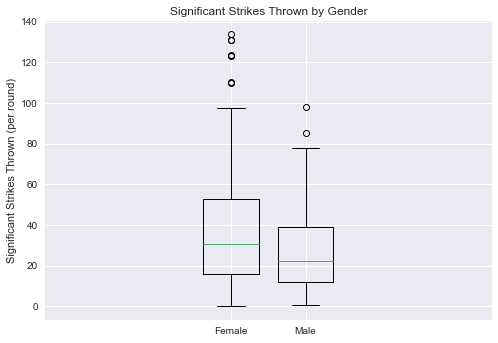

In [354]:
plt.boxplot([sig_strikes_thrown_f['strikes_thrown'],sig_strikes_thrown_m['strikes_thrown']],
            labels=['Female','Male'],
            positions=[0.9,1.1])

plt.ylabel('Significant Strikes Thrown (per round)')
plt.title('Significant Strikes Thrown by Gender')

plt.show()

A very similar pattern is found for strikes landed. Female fighters land around 17 strikes per round on average, which is 5 strikes more than male fighters, who land around 12 per round. Again, the difference was shown to be highly statistically significant (p < 0.0001) with a similar effect size of 0.39.

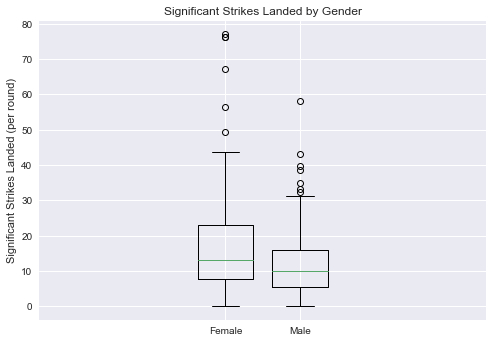

In [355]:
plt.boxplot([sig_strikes_landed_f['strikes_landed'],sig_strikes_landed_m['strikes_landed']],
            labels=['Female','Male'],
            positions=[0.9,1.1])

plt.ylabel('Significant Strikes Landed (per round)')
plt.title('Significant Strikes Landed by Gender')

plt.show()

Regarding striking accuracy, there was no significant difference between females and males, with both men and women landing around 44% of their strikes (p = 0.8415). This suggests that gender makes no significant difference to striking accuracy, which can be seen in the visualisation below:

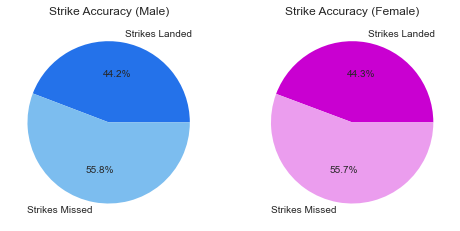

In [357]:
fig,axs = plt.subplots(1,2)

strikes_landed_f = sig_strike_acc_f['strikes_succ'][0]
strikes_missed_f = sig_strike_acc_f['strikes_att'][0] - sig_strike_acc_f['strikes_succ'][0]
strikes_landed_m = sig_strike_acc_m['strikes_succ'][0]
strikes_missed_m = sig_strike_acc_m['strikes_att'][0] - sig_strike_acc_m['strikes_succ'][0]

axs[0].pie([strikes_landed_m,strikes_missed_m],
        labels=['Strikes Landed','Strikes Missed'],
        autopct='%1.1f%%',
        colors=('#2472EA','#7CBDEF'))

axs[1].pie([strikes_landed_f,strikes_missed_f],
        labels=['Strikes Landed','Strikes Missed'],
        autopct='%1.1f%%',
        colors=('#C900D1','#EB9DEE'))

axs[0].set_title('Strike Accuracy (Male)')
axs[1].set_title('Strike Accuracy (Female)')


plt.show()

Finally, male fighters landed more knockdowns per round than female fighters. Knockdowns are relatively rare in MMA, and so both male and female fighters land well below 1 knockdown per round on average. Women land 0.02 knockdowns per round, which is 0.04 less than men, who land 0.06 per round. This difference significant at the 0.01 level, with a small effect size of 0.33.

### Grappling Performance

Unlike striking, there was no significant difference in grappling between men and women except in control time. In the sampels we drew, there was no significant difference in the number of takedowns attempted, the number of takedowns landed, takedown success rate, or the number of submission attempts.

In [344]:
grappling_mean_summary = {'Fight Metric (per round)':['Takedowns Attempted',
                   'Takedowns Landed',
                   'Submissions Attempted',
                   'Control Time'],
           'Female Average':[1,0.36,0.11,58.51],
           'Male Average':[1.07,0.38,0.14,41.87],
           'Difference':['-0.07','-0.02','-0.03','+16.64'],
           'p-value':['p = 0.5841','p = 0.6618','p = 0.3508','p = 0.0034'],
           'Significant':['N','N','N','Y**'],
           'Effect Size (Cohen\'s D)':[0.05,0.04,0.09,0.29],}

pd.DataFrame(data=grappling_mean_summary)

,Fight Metric (per round),Female Average,Male Average,Difference,p-value,Significant,Effect Size (Cohen's D)
0,Takedowns Attempted,1.00,1.07,-0.07,p = 0.5841,N,0.05
1,Takedowns Landed,0.36,0.38,-0.02,p = 0.6618,N,0.04
2,Submissions Attempted,0.11,0.14,-0.03,p = 0.3508,N,0.09
3,Control Time,58.51,41.87,+16.64,p = 0.0034,Y**,0.29


In [345]:
grappling_summary_proportion = {'Variable':['Takedown Success Rate'],
                     'Female Proportion':[0.358],
                     'Male Proportion':[0.354],
                     'Difference':['-0.02'],
                     'p-value':['p = 0.9106'],
                     'Significant':['N']}

pd.DataFrame(data=grappling_summary_proportion)

,Variable,Female Proportion,Male Proportion,Difference,p-value,Significant
0,Takedown Success Rate,0.358,0.354,-0.02,p = 0.9106,N


Comparing takedowns attempts from our samples, men attempted 1.07 takedowns on average per round, while women attempted 1. This small difference of 0.07 was not found to be significant (p > 0.05).

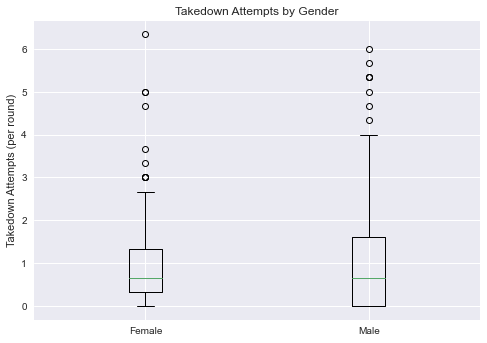

In [346]:
plt.boxplot([td_attempts_f['takedown_attempts'],td_attempts_m['takedown_attempts']],
            labels=['Female','Male'])

plt.ylabel('Takedown Attempts (per round)')
plt.title('Takedown Attempts by Gender')

plt.show()

Similarly, when comparing takedowns landed, men landed 0.02 more takedowns than women per round (0.36 and 0.38 respecrtively). However, again this difference was not significant at the 0.05 level.

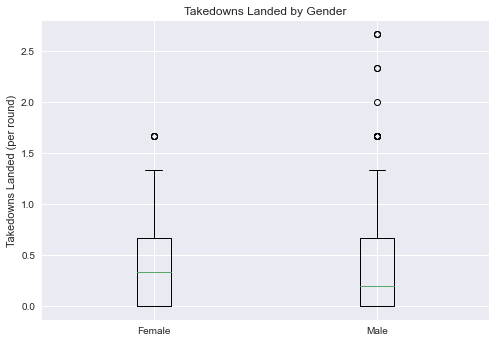

In [362]:
plt.boxplot([td_landed_f['takedowns_landed'],td_landed_m['takedowns_landed']],
            labels=['Female','Male'])

plt.ylabel('Takedowns Landed (per round)')
plt.title('Takedowns Landed by Gender')

plt.show()

Given that there was no significant difference between men and women in terms of number of takedown attempts and successful takedowns, it is unsurprising that there was no significant difference between takedown success rate of men and women:

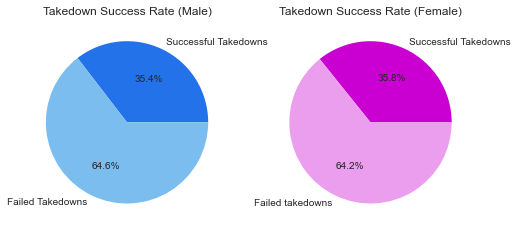

In [363]:
fig,axs = plt.subplots(1,2)

takedowns_landed_f = takedown_succ_rate_f['takedown_succ'][0]
takedowns_missed_f = takedown_succ_rate_f['takedown_att'][0] - takedown_succ_rate_f['takedown_succ'][0]
takedowns_landed_m = takedown_succ_rate_m['takedown_succ'][0]
takedowns_missed_m = takedown_succ_rate_m['takedown_att'][0] - takedown_succ_rate_m['takedown_succ'][0]

#Takedown success rate for men
axs[0].pie([takedowns_landed_m,takedowns_missed_m],
        labels=['Successful Takedowns','Failed Takedowns'],
        autopct='%1.1f%%',
        colors=('#2472EA','#7CBDEF'))

#Takedown success rate for women
axs[1].pie([takedowns_landed_f,takedowns_missed_f],
        labels=['Successful Takedowns','Failed takedowns'],
        autopct='%1.1f%%',
        colors=('#C900D1','#EB9DEE'))

axs[0].set_title('Takedown Success Rate (Male)')
axs[1].set_title('Takedown Success Rate (Female)')

plt.show()

However, comparing control time between men and women did show a significant difference. On average, female fighters displayed around 17 seconds more control time per round than men, which was significant at the 0.01 level, with a small effect size of 0.29.

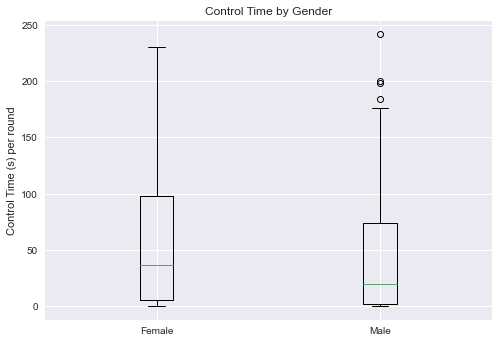

In [364]:
plt.boxplot([ctrl_time_f['ctrl_time_seconds'],ctrl_time_m['ctrl_time_seconds']],
            labels=['Female','Male'])

plt.ylabel('Control Time (s) per round')
plt.title('Control Time by Gender')

plt.show()

### Fight Result

Looking at the distribution of decisions, KO/TKOs, and submissions across genders, we found that gender does have a significant effect on the way a fight ends. The test resulted in a chi-squared value of 15.88, and p = 0.0012, which is significant at the 0.01 level. The graph below visually displays how the two distributions differ:

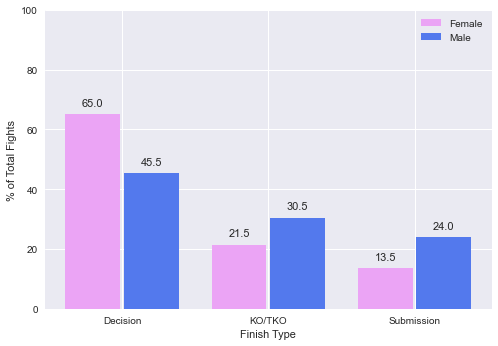

In [359]:
x = ['Decision','KO/TKO','Submission']

male = [45.5,30.5,24]
female = [65,21.5,13.5]
x_axis = np.arange(len(x))

female_bar = plt.bar(x_axis-0.2,female,0.375,color='#eba4f5',label='Female')
male_bar = plt.bar(x_axis+0.2,male,0.375,color='#5379ed',label='Male')

plt.ylabel('% of Total Fights')
plt.xlabel('Finish Type')
plt.legend()
plt.xticks(x_axis,x)
plt.ylim((0,100))

for bar in female_bar:
    plt.annotate(format(bar.get_height(), '.1f'),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center',
            size=11, xytext=(0,8),
            textcoords='offset points')

for bar in male_bar:
    plt.annotate(format(bar.get_height(), '.1f'),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center',
            size=11, xytext=(0,8),
            textcoords='offset points')
    
    
plt.show()

To see whether there was a significant difference between each of these individual proportions, I ran a z-test for difference of proportions on each finish type:

In [367]:
result_summary = {'Result':['Decision',
                   'KO/TKO',
                   'Submission'],
           'Female Proportion':[0.65,0.215,0.135],
           'Male Proportion':[0.455,0.305,0.24],
           'Difference':['+0.195','-0.09','0.105'],
           'p-value':['p < 0.0001','p = 0.0401','p = 0.0071'],
           'Significant':['Y***','Y*','Y**']}
pd.DataFrame(data=result_summary)

,Result,Female Proportion,Male Proportion,Difference,p-value,Significant
0,Decision,0.650,0.455,+0.195,p < 0.0001,Y***
1,KO/TKO,0.215,0.305,-0.09,p = 0.0401,Y*
2,Submission,0.135,0.240,0.105,p = 0.0071,Y**


We can see that female fights are around 20% likely to result in a decision. 65% of female fights ended in decision compared to 45.5% of male fights. This difference was highly significant (p < 0.0001).

Conversely, male fights are 20% more likely to end in a finish, either a KO/TKO or a submission. 30.5% of male fights ended in a KO/TKO, compared to 21.5% of female fights, and this difference was significant at the 0.05 level.

Similarly, male fights are 10% more likely to end in submission: while 13.5% of female fights ended in submission, 24% of male fights ended in submission, and this difference was significant at the 0.01 level.

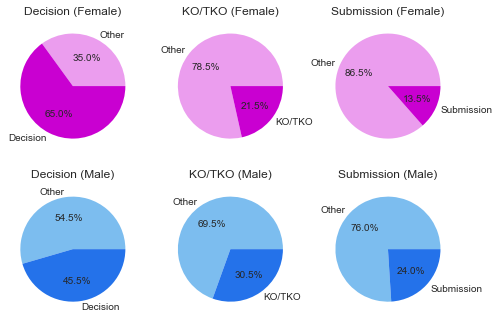

In [368]:
fig,axs = plt.subplots(2,3)

#Female 

#Decision
axs[0,0].pie([70,130],
        labels=['Other','Decision'],
        autopct='%1.1f%%',
        colors=('#EB9DEE','#C900D1'))
axs[0,0].set_title('Decision (Female)')

#KO/TKO
axs[0,1].pie([157,43],
        labels=['Other','KO/TKO'],
        autopct='%1.1f%%',
        colors=('#EB9DEE','#C900D1'))
axs[0,1].set_title('KO/TKO (Female)')

#Submission
axs[0,2].pie([173,27],
        labels=['Other','Submission'],
        autopct='%1.1f%%',
        colors=('#EB9DEE','#C900D1'))
axs[0,2].set_title('Submission (Female)')


#Male

#Decision
axs[1,0].pie([109,91],
        labels=['Other','Decision'],
        autopct='%1.1f%%',
        colors=('#7CBDEF','#2472EA'))

axs[1,0].set_title('Decision (Male)')

#KO/TKO
axs[1,1].pie([139,61],
        labels=['Other','KO/TKO'],
        autopct='%1.1f%%',
        colors=('#7CBDEF','#2472EA'))
axs[1,1].set_title('KO/TKO (Male)')

#Submission
axs[1,2].pie([152,48],
        labels=['Other','Submission'],
        autopct='%1.1f%%',
        colors=('#7CBDEF','#2472EA'))
axs[1,2].set_title('Submission (Male)')



plt.show()

## Discussion

What are the key insights that can be drawn from this analysis? The main question this analysis attempted to answer was 'how does gender affect MMA performance?' 

The results from comparing a sample of 200 male and 200 female UFC fighters between 125-145lbs suggest that in terms of striking, women's fights are higher paced than men's, although you're more likely to see knockdowns and knockouts in men's fights. When it comes to grappling, women control their opponent for longer on average, whereas men are more likely to submit their opponent.

On average, women's strike rate is ~40% higher than men's throughout a fight. On average, male fighters throw around 27 strikes in a round, while female fighters throw 10 more strikes per round. Across a three round fight, taking into account both fighters, you will see 60 more strikes in a women's UFC fight than a men's UFC fight. In terms of striking accuracy, there was no significant difference between men and women, with both genders landing around 44% of their strikes. However, given that women throw 40% more strikes each round, this results in just under 30 more strikes landing in an average female fight than an average male fight.

On the other hand, despite throwing fewer strikes, the strikes thrown by men appear to do more damage when looking at knockdowns and knockouts. Although the likelihood of knockdowns is relatively low for both genders, there are 3x as many knockdowns in men's fights than women's fights. Our results found that on average, you would need to watch 16 rounds of male UFC fights to see a knockdown, whereas you would need to watch 50 rounds of female UFC fights to see a knockdown. Male fights are also more likely to end in a KO or TKO. 30% of male fights in our sample ended in a KO or TKO, compared to 21% of female fights.

In terms of grappling, no significant differences were found in the takedown stats of men and women. However, women showed significantly higher control time than men - around 16 second per round. This suggests that although women are equally likely to shoot a takedown in a fight, with equal success rate, female fights spend longer periods of time grappling after a successful takedown. Despite spending more time grappling, it appears that the grappling in women's fights is less effective in terms of submissions: men's fights are almost 2x more likely to end in a submission. 24% of male UFC fights in our sampled ended in submission, compared to 13.5% of female UFC fights. However, we did not compare ground and pound strikes (i.e. strikes from a dominant grappling position), so it is possible that female fighters are more likely to go for ground and pound over submissions.

In conclusion, these results strongly imply that gender does affect MMA performance. Looking at some key striking and grappling stats, we see female fights are higher paced, with a higher strike rate and more grappling, whereas men's fights involve more measurable damage, specifically more knockdowns, knockouts, and submissions. 

This analysis only focused on some overall fight stats, however the analysis could be extended to more specific stats in future. For example, does gender affect the type of striking, e.g. do women throw more kicks than men? Do men head-hunt more than women?, etc. Or does gender affect fighting stance? In terms of grappling, do men favour different submissions to women? I am excited to see how others use this dataset for future analyses: https://www.kaggle.com/datasets/remypereira/mma-dataset-2023-ufc?select=ufc_fights.csv. 